In [11]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random

### Define Hyperparameters

In [12]:
batch_size = 4
n_classes = 5

### Define Computation Graph

In [13]:
def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

In [23]:
# def scale_and_shift_flat(x, labels, name='s_and_s'):
#     with tf.variable_scope(name, reuse=None):
#         axis = [1,2]
#         x_shape = x.get_shape().as_list()
#         beta = tf.get_variable( 'beta', [n_classes])
#         gamma = tf.get_variable( 'gamma', [n_classes])

#         class_shift = tf.gather(beta, labels)
#         class_shift = tf.expand_dims(class_shift, 1)

#         class_scale = tf.gather(gamma, labels)
#         class_scale = tf.expand_dims(class_scale, 1)

#         output = x + class_shift
#         output *= class_scale
#         return output

def scale_and_shift_flat(x, labels, name='s_and_s'):
    with tf.variable_scope(name, reuse=None):
        axis = [1,2]
        x_shape = x.get_shape().as_list()
        print('x shape: {}'.format(x.get_shape().as_list()))
        
        beta = tf.get_variable( 'beta', [n_classes])
        gamma = tf.get_variable( 'gamma', [n_classes])

        class_shift = tf.gather(beta, labels)
        class_shift = tf.expand_dims(class_shift, 1)
        print('class shift shape: {}'.format(class_shift.get_shape().as_list()))

        class_scale = tf.gather(gamma, labels)
        class_scale = tf.expand_dims(class_scale, 1)
        print('class scale shape: {}'.format(class_scale.get_shape().as_list()))

        variance_epsilon = 0.01
        mean, variance = tf.nn.moments(x, axis, keep_dims=True)
        print('mean shape: {}'.format(mean.get_shape().as_list()))
        print('variance shape: {}'.format(variance.get_shape().as_list()))
        output = tf.nn.batch_normalization(x=x, mean=mean,
                                           variance=variance,
                                           offset=class_shift, scale=class_scale,
                                           variance_epsilon=variance_epsilon)
        return output

In [28]:
def scale_and_shift(x, labels, name='s_and_s'):
    with tf.variable_scope(name, reuse=None):
        axis = [1]
        x_shape = x.get_shape().as_list()
        beta = tf.get_variable( 'beta', [n_classes])
        gamma = tf.get_variable( 'gamma', [n_classes])
        
        class_shift = tf.gather(beta, labels)
        class_shift = tf.expand_dims(tf.expand_dims(tf.expand_dims(class_shift, 1), 1), 1)
        
        class_scale = tf.gather(gamma, labels)
        class_scale = tf.expand_dims(tf.expand_dims(tf.expand_dims(class_scale, 1), 1), 1)
        
        variance_epsilon = 0.01
        mean, variance = tf.nn.moments(x, axis, keep_dims=True)
        output = tf.nn.batch_normalization(x=x, mean=mean,
                                           variance=variance,
                                           offset=class_shift, scale=class_scale,
                                           variance_epsilon=variance_epsilon)
        return output

    

In [29]:
def encoder(X_in, labels, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 210, 160, 3])
        
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = scale_and_shift(x, labels, name='s_and_s/1')
        x = tf.nn.dropout(x, keep_prob)
        
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = scale_and_shift(x, labels, name='s_and_s/2')
        x = tf.nn.dropout(x, keep_prob)
        
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = scale_and_shift(x, labels, name='s_and_s/3')
        x = tf.nn.dropout(x, keep_prob)
        
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        sd = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        return z, mn, sd

In [30]:
def decoder(sampled_z, labels, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        x = scale_and_shift_flat(x, labels, name='s_and_s/4')
        
        x = tf.layers.dense(x, units=(inputs_decoder * 2 + 1), activation=lrelu)
        x = scale_and_shift_flat(x, labels, name='s_and_s/5')
        x = tf.reshape(x, reshaped_dim)
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = scale_and_shift(x, labels, name='s_and_s/6')
        x = tf.nn.dropout(x, keep_prob)
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = scale_and_shift(x, labels, name='s_and_s/7')
        x = tf.nn.dropout(x, keep_prob)
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = scale_and_shift(x, labels, name='s_and_s/8')
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=210*160*3, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 210, 160, 3])
        return img

In [31]:
tf.reset_default_graph()

batch_size = 4
n_classes = 10

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 210, 160, 3], name='X')
Labels = tf.placeholder(dtype=tf.int32, shape=[None], name='Labels')
Y = tf.placeholder(dtype=tf.float32, shape=[None, 210, 160, 3], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 210 * 160 * 3])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels // 2

sampled, mn, sd = encoder(X_in, Labels, keep_prob)
dec = decoder(sampled, Labels, keep_prob)

unreshaped = tf.reshape(dec, [-1, 210*160*3])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)

# introduce variable learning rate
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.0005
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           1000, 0.96, staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

x shape: [None, 24]
class shift shape: [None, 1]
class scale shape: [None, 1]


ValueError: Invalid reduction dimension 2 for input with 2 dimensions. for 'decoder/s_and_s/4/moments/Mean' (op: 'Mean') with input shapes: [?,24], [2] and with computed input tensors: input[1] = <1 2>.

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Gather New Training Data

In [6]:
directories = ['jamesbond', 'spaceinvaders', 'tutankham', 'venture', 'zaxxon']
state_label_pairs = []
for i, root_dir in enumerate(directories):
    for dir_name, subdir_list, file_list in os.walk(root_dir+'/'):
        for fname in file_list:
            state_label_pairs.append((root_dir + '/' + fname, i))

print('Found {} files.'.format(len(state_label_pairs)))

Found 500 files.


### Train the Model

In [8]:
def read_image(filename):
    image = np.load(filename)
    print(image.shape)
    plt.imshow(image)
    plt.show()
    return image

(210, 160, 3)


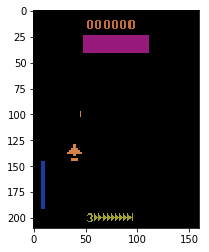

(210, 160, 3)


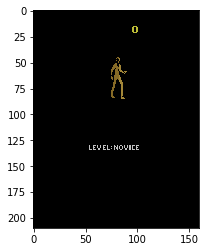

(210, 160, 3)


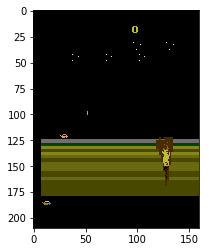

(210, 160, 3)


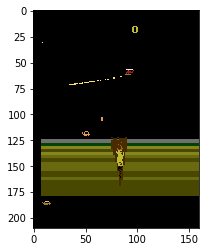

In [9]:
batch_losses = []
avg_img_losses = []
sparse_batch_losses = []

for i in range(1):
    next_batch = random.sample(state_label_pairs, batch_size)
    batch = [read_image(b[0]) for b in next_batch]
    labels = [lab[1] for lab in next_batch]
    batch_loss, batch_img_loss, _ = sess.run([loss, img_loss, optimizer], feed_dict = {X_in: batch, Y: batch, Labels: labels, keep_prob: 0.8})
    batch_losses.append(batch_loss)
    avg_img_losses.append(np.mean(batch_img_loss))
        
    if not i % 200:
        batch_loss, decoded, batch_img_loss, mu, sigm = sess.run([loss, dec, img_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, Labels: labels, keep_prob: 1.0})
        batch_losses.append(batch_loss)
        sparse_batch_losses.append(batch_loss)
        avg_img_losses.append(np.mean(batch_img_loss))
        
        plt.imsave(fname='multi_vae_results/iteration_{}_original.png'.format(i), arr=np.reshape(batch[0], [210, 160, 3]), format='png')
        plt.imsave(fname='multi_vae_results/iteration_{}_reconstructed.png'.format(i), decoded[0], format='png')
        
        plt.title('Batch losses')
        plt.plot(np.arange(len(batch_losses)), batch_losses)
        plt.tight_layout()
        plt.savefig('multi_vae_results/iteration_{}_batch_losses', dpi=300)
        
        plt.title('Sparse Batch losses')
        plt.plot(np.arange(len(sparse_batch_losses)), sparse_batch_losses)
        plt.tight_layout()
        plt.savefig('multi_vae_results/iteration_{}_sparse_batch_losses', dpi=300)
        
        print('iteration: {}; batch loss: {}, mean img loss: {}'.format(i, batch_loss, np.mean(batch_img_loss)))

### Sample New Images

In [10]:
n_samples = 10
randoms = [np.random.normal(0, 1, n_latent) for _ in range(n_samples)]
classes = [np.random.choice(n_classes) for _ in range(n_samples)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [210, 160, 3]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    
n_samples = 10
randoms = [np.random.normal(0, 1, n_latent) for _ in range(n_samples)]
labels = [np.random.choice(n_classes) for _ in range(n_samples)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, Labels: labels, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [210, 160, 3]) for i in range(len(imgs))]

for i, img, c in zip(range(n_samples, imgs, classes)):
    plt.imsave(fname='multi_vae_results/reconstruction_{}_class_{}'.format(i, c), arr=img, format='png')

SyntaxError: invalid syntax (<ipython-input-10-8eb0b940e899>, line 23)